# Guess the location - Project Part A

In this part of the project, the neural networks learns to distinguish some locations giving it in input some features of them, their weather conditions. In particular, the fully connected neural networks receveis in input 7 features (min temperature, max temperature, rain precipitation, snowfall, snowdepth and average temperature) for each day of 1 year for each location. In output there are as many neurons as the number of locations the network learned to distinguish. Only the correct neuron must activate itself firing at 1, while the neurons should remain at 0 or at a low value (in the ideal case).

In [1]:
import glob #used to find the packet of the dataset
import gzip #used to extract the packets of the dataset
import os
import pandas as pd #to manage dataframe
from tqdm import tqdm #to plot the status bar of the computations
import plotly #to create graphs
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cartopy #to draw the world map
import cartopy.crs as ccrs
import random
import numpy

from dataset import creation_dataset,construction,split_dataset
from IAHOS import IAHOS
from hyperparams_initialization import hyperparams_initialization
from extraction_performances import extraction_performances
from plots import plot_earth_trainvaltest,plot_earth,plot_split,plot_quality

# Section 1

All the cells of section 1 must not be permormed beacuse they belong to an entire pre-processing of the dataset that has already been perfofmed. They are reported only to show the work that was necessary.

The next cell serves to find all the .gz files with that name that you decide to extract

In [ ]:
files = glob.glob("201*.gz")
files.sort()
print (files)

With the use of pandas library, is created a dataframe that is filled with the informations found in the extracted file. Only the columns "Code", "Date", "Variable" and "Value" are inserted in the dataframe. At the end of the cell, the dataframe is saved on disk

In [ ]:
df = pd.DataFrame(columns = ['Code', 'Date', 'Variable', 'Value', '7','Location','Latitude', 'Longitude', 'Height'])
for i in tqdm(range(1)):
    with gzip.open(files[i]) as f:
        frame = pd.read_csv(f, names = ['Code', 'Date', 'Variable', 'Value', '5', '6', '7','8'])
        frame = frame.drop(columns = ['5','6','8']) #delete the columns not needed
        df = df.append(frame, sort = False)
#df.sort_values(by=['Country'])
df.to_pickle("data2010.pkl") #save the dataframe on disk

In [ ]:
del df
df0 = pd.read_pickle("./data2010.pkl") #read the dataframe from the disk
#df1 = pd.read_pickle("./data18xxx.pkl")
#df2 = pd.read_pickle("./data190x.pkl")
#df3 = pd.read_pickle("./data191x.pkl")

frames = [df0]
result = pd.concat(frames) #if we concatenate more dataframe in only one dataframe

print (result.head())

In [ ]:
result = result.sort_values(by=['Code'])

# Associate location to the base stations

In the following cell, is read a .csv file containing all the informations about the base stations: latitude, longitude, height and the name of the location correspondent. In this way in the next cell, each base station code is associated to the proper location.

In [ ]:
df1 = pd.DataFrame(columns = ['Code', 'Latitude', 'Longitude', 'Height', 'City'])
frame = pd.read_csv('stations2.csv', names= ['Code', 'Latitude', 'Longitude', 'Height', 'City'],sep=";")
df1 = df1.append(frame, sort = False)
print (df1.head())

In [ ]:
creation_dataset(result,df1)

# Section 2

The next one is the first cell that must be computed. It loads the dataset 

In [2]:
df0 = pd.read_pickle("./dataset/data0.pkl")
df1 = pd.read_pickle("./dataset/data1.pkl")
df2 = pd.read_pickle("./dataset/data2.pkl")
#df3 = pd.read_pickle("./dataset/data3.pkl")
#df4 = pd.read_pickle("./dataset/data4.pkl")
#df5 = pd.read_pickle("./dataset/data5.pkl")
#df6 = pd.read_pickle("./dataset/data6.pkl")
#df7 = pd.read_pickle("./dataset/data7.pkl")
df8 = pd.read_pickle("./dataset/data8.pkl")
frames = [df0,df1,df2,df8]#which pieces of the dataset I want to import
result = pd.concat(frames)#concate them to create an unique dataset

In [3]:
Locations = np.array(result.Code.unique())#extract the list of all the locations found in the imported dataset

In the following cells, onyl 10 locations are inserted in the dictionaries to show which are the problems of the dataset. Then a higher number of places are founded in the proper way and added to the dictionaries.

In [4]:
samples = []#create  containing random numbers to sample random locations
size_samples = 10#number of locations inserted
for i in range(size_samples):
    samples.append(random.randint(0,Locations.size-1))#add the random numbers to the 
d = {}
for i in tqdm(range(size_samples)):#insert in the dictionary the locations sampled at random
    d[Locations[samples[i]]] = result.loc[result['Code'] == Locations[samples[i]]].sort_values(by=['Date'])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


In [5]:
e,f=construction(size_samples,0,0,0,0,0,0,Locations,samples,d)
#elaborate all the locations without constraints

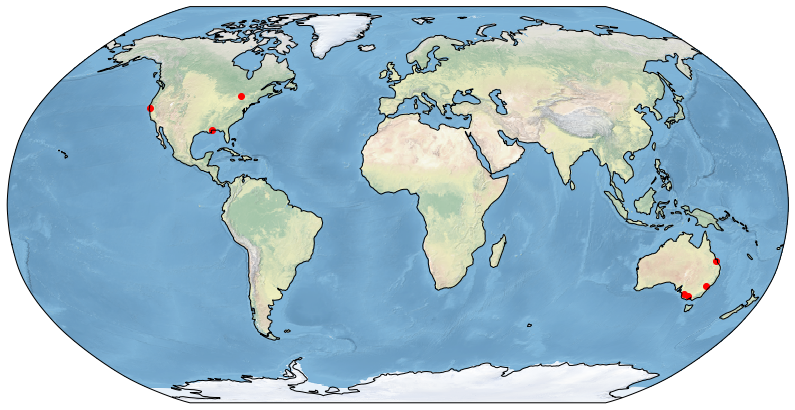

In [10]:
plot_earth(d,e,'first_sample')

# Completeness of the dataset

The neural network learns better to distinguish between locations if we have more features to describe each location. The major problem of this dataset, is the lack of informations about a feature for a certain location, or another feature for other places. Since the project is thought to work with a very big dataset, we cannot scroll down all the rows of each location to control if there are all the elements af all the features, day by day. So the following heatmap represents, in percentage, the informations about every feature of each location. For example, if we have the Tmin of a certain place for all the days of the year, we have 100% knowledge about that feature of that place (green), otherwise a minor knowledge, so a lower percentage that means a color closer to the red one.


In [7]:
plot_quality(d,f,'first')

Another problem is the lack of geospatial homogeneity. We would like to sample places randomly from the entire world. But in the dataset some countries have many more sample with respect to others. So this world map help to see which countries are added to the dictionary. Unfortunately, here are represented only the locations that have a corresponding association in the text file described at the beginning. In other words, only those places of which we know latitude and longitude because they are present in the text file.

Now instead I want to use only those places whose location is known (Code present in the text file) and that have enough informations during the year, filtered them and inserting only them in the dictionaries

In [11]:
from tqdm import tqdm_notebook as tqdm
del d #delete old dictionary containing all the informations about the places imported
del e #delete old dictionary containing the weather conditions of each location after the processing
del f #delete old dictionary containing quality of features of each locations
del samples #delete old dictionary containing random numbers used to sample random locations
samples = [] #create new dictionary
size_samples = 300 #number of locations we control
for i in range(size_samples):
    samples.append(random.randint(0,Locations.size-1))
d = {} #create new dictionary
e={} #create new dictionary
f={} #create new dictionary
indeces_useless = []
new_samples = []
for i in tqdm(range(size_samples)):
    key = Locations[samples[i]]#the 'key' vector contains the codes of the locations sampled at random
    if result.loc[result['Code'] == Locations[samples[i]]].Location.isnull().values.any()==False:#we add only places whose location is known         
        new_samples.append(samples[i])
        d[key] = result.loc[result['Code'] == key].sort_values(by=['Date']) #Insert in the dictionary the correspondent locations
del samples
samples = []
for i in range(len(new_samples)):
    samples.append(new_samples[i])
e,f=construction(len(d),0.95,0.95,0,0,0,0,
                Locations,samples,d) #Insert in the 2 dictionaries only that locations that satisfy
#some requirements on the qualities of the input features. In this case I want that in the 2 dictionaries are put only 
#those locations that have at least 95% of samples of their minimum and maximum daily temperature, daily average
#temperature and daily rain precipitation
print ("The total number of locations analyzed is: ",size_samples)
print ("The total number of locations whose location is known is: ",len(d))
print ("The total number of locations inserted in the dictionary is :",len(e)) 


The total number of locations analyzed is:  300
The total number of locations whose location is known is:  218
The total number of locations inserted in the dictionary is : 54


In [12]:
training_set,validation_set,test_set,labels,values1,values2,values3=split_dataset(e)

In [13]:
plot_split(labels,values1,values2,values3)

In [14]:
plot_quality(d,f,'final')

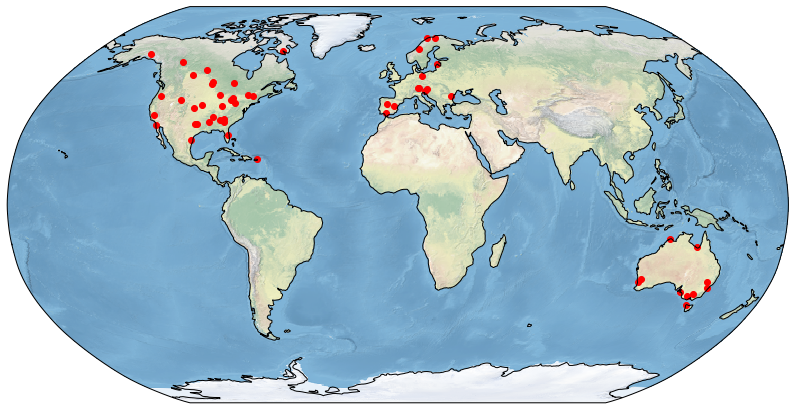

In [15]:
plot_earth(d,e,'final')

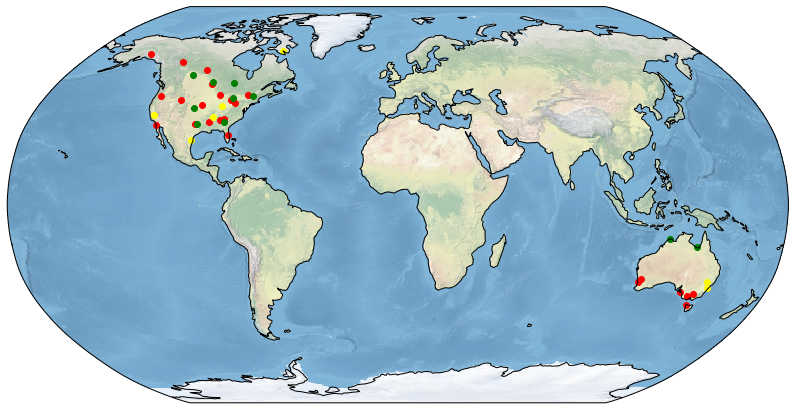

In [16]:
plot_earth_trainvaltest(training_set,validation_set,test_set,d)

Dataset Neural Network creation

In [17]:
x_train = np.zeros((365*len(training_set),7))
x_val = np.zeros((365*len(validation_set),7))
x_test = np.zeros((365*len(test_set),7))

k=0
for j in training_set:
    for i in range(365):  
        x_train[i+365*k]=training_set[j][i]
    k=k+1

k=0
for j in validation_set:
    for i in range(365):  
        x_val[i+365*k]=validation_set[j][i]
    k=k+1    

k=0
for j in test_set:
    for i in range(365):  
        x_test[i+365*k]=test_set[j][i]
    k=k+1

In [ ]:
x_clustering = np.zeros((len(e),365*2))
for i in range(len(e)):
    for j in range(365):
        x_clustering[i,2*j]=x_train[365*i+j,0]
        x_clustering[i,2*j+1]=x_train[365*i+j,1]

In [ ]:
from kmeans_pytorch import lloyd
clusters_index, centers = lloyd(x_clustering, 3, device=torch.device("cuda"), tol=1)

In [ ]:
class Net(nn.Module):
    def __init__(self,Ni,i,hm,No,mode):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, Nh2)
        self.fc4 = nn.Linear(Nh2, No)
        
        self.act = nn.ReLU()
        self.act2 = nn.Softmax()
        
    def forward(self,x,additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        for i in range(int(hm[2,i])):
            x = self.act(self.fc3(x))
        out = self.act2(self.fc4(x))
        return out

In [ ]:
attempts=2
variables=5
iterations=attempts**variables
limits = [[100,500],[0,0.5],[0,3],[100,500],[0,0.5]]
method='grid'
rounds=2
tgp,tgp2,ogp,ogp2,final=IAHOS(rounds,method,limits,attempts,variables,iterations,Net,
                       x_train,y_train,x_val,y_val)

In [ ]:
def evaluate(data_loader):
    net.eval()
    loss = 0
    correct = 0
    
    for target in y_train:
        if torch.cuda.is_available():
            x_train = x_train.cuda()
            target = target.cuda()
        
        output = net(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data[0]

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [ ]:
n_epochs = 1
train_loader = torch.utils.data.DataLoader(dataset=x_train,
                                           batch_size=100, shuffle=True)
for epoch in range(n_epochs):
    evaluate(train_loader)

In [ ]:
plt.close('all')
plt.figure(figsize=(8,6))
plt.semilogy(train_loss_log,label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show
print (loss.data)

In [ ]:
def graph(key):    
    values = e[key]#import all the rows corresponding to that location
    plotly.offline.init_notebook_mode()
    x1 = np.arange(1,365)
    Tmin = np.array(values.T)[0]
    Tmax = np.array(values.T)[1]
    Rain = np.array(values.T)[3]/100
    Snow = np.array(values.T)[4]
    Snwd = np.array(values.T)[5]/10
    Tavg = np.array(values.T)[6]
    trace0 = go.Scatter(x=x1,y=Tmin,name="Min Temperature",mode="lines+markers")
    trace1 = go.Scatter(x=x1,y=Tmax,name="Max Temperature",mode="lines+markers")
    trace2 = go.Scatter(x=x1,y=Tavg,name="Average temperature",mode="lines+markers")
    trace3 = go.Bar(x=x1,y=Rain,name="Daily rain precipitations (mm)")
    K1=1
    K2=1
    for i in range(365):
        if Snow[i]>50:
            K1=10
    for i in range(365):
        if Snwd[i]>50:
            K2=10
    if K1 == 1:
        trace4 = go.Bar(x=x1,y=Snow/K1,name="Daily snow precipitations")
    else:
        trace4 = go.Bar(x=x1,y=Snow/K1,name="Daily snow precipitations [tenths of mm]")
    if K2 == 1:
        trace5 = go.Bar(x=x1,y=Snwd/K2,name="Daily snowfall")
    else:
        trace5 = go.Bar(x=x1,y=Snwd/K2,name="Daily snowfall [tenths of mm]")
    mydata = go.Data([trace0, trace1, trace2, trace3,trace4,trace5])
    mylayout = go.Layout(title="Weather conditions in "+d[key].iloc[0]['Location'],xaxis=dict(title='Days of the year'))
    fig = go.Figure(data=mydata, layout=mylayout)
    plotly.offline.iplot(fig, filename = d[key].iloc[0]['Location'])

In [ ]:
print (e.keys())

In [ ]:
#copy one of the keys of the previous cell inside code and plot that location
code = 'ASN00010917'
graph(code)

In [ ]:
net.eval()
with torch.no_grad():
    out = net(torch.tensor([10,30,1,0,0,0,20]).float().cuda())
out = out.cpu()

In [ ]:
out = out.squeeze().numpy()
plt.close('all')
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(out)),out)
plt.grid()
plt.xlim([0,len(out)])
plt.xlabel('Location')
plt.ylabel('Location probability')
plt.tight_layout()
plt.show()
Most_probable_location = names[out.argmax()]
print ('The most probable location is: ',Most_probable_location)

In [ ]:
del x_train
x_train = np.zeros((365*len(e),7)) #create the matrix used to feed the neural network, that has as many rows as the 
#number of locations inserted in the dictionary times 365, because for each location I analyzed an entire year, and as
#many columns as the number of input features
k=0
for j in e:#The matrix is filled in this way: Each row correspond to a different location, to let the network train with
    for i in range(365):#a different location at each time step, and not with all the 365 rows of a location  
        x_train[len(e)*i+k]=e[j][i]#So the first 365 rows are rifered to the first day of the year of all the locations, the
    k=k+1#second 365 rows to the second day of the year of all the locations and so on
#For this reason the correct output, that is a vector contains 1 in the position of the correct location and 0 in all other 
del y_train
y_train = np.zeros((365*len(e),2))
k=0
for j in e: #again at the first position and all the other neurons set to 0
    for i in range(365):
        y_train[len(e)*i+k,0]=d[j].iloc[0].Latitude/10
        y_train[len(e)*i+k,1]=d[j].iloc[0].Longitude/10
    k=k+1

In [ ]:
del net
class Net(nn.Module):
    def __init__(self,Ni,Nh1,Nh2,No):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)
        self.act = nn.Sigmoid()
    def forward(self,x,additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        out = self.fc3(x)
        return out
    

            
Ni = 7
Nh1 = 400
Nh2 = 400
No = 2
net = Net(Ni,Nh1,Nh2,No)
loss_fn = nn.MSELoss()
#Convert to tensor object
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
net.to(device)

x_train = torch.tensor(x_train).float().view(-1,7).cuda()
y_train = torch.tensor(y_train).float().view(-1,2).cuda()

#Check tensor shapes
#print (x_train.shape)
#print (y_train.shape)
#Learning rate
lr = 0.05
num_epochs = 50000

#update
train_loss_log = []
test_loss_log = []
net.train()
for num_ep in tqdm(range(num_epochs)):
    net.zero_grad()
    out = net(x_train)
    loss = loss_fn(out,y_train)
    loss.backward()
    for p in net.parameters():
        p.data.sub_(p.grad.data * lr)
    train_loss_log.append(float(loss.data))
    #print('Epoch %d - lr: %.5f - Train loss: %.5f' % (num_ep+1,lr,float(loss.data)))
os.system('spd-say "your program has finished"')

In [ ]:
plt.close('all')
plt.figure(figsize=(8,6))
plt.semilogy(train_loss_log,label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show
print ('Final loss: ',loss.data[0].item())

In the following cell, is performed the test of the neural network. Inside the square brackets there are 7 values, in order: minimum temperature, maximum temperature, the day of the year (from 0 to 364), the rain precipitation, the snowfall, the snowdepth. Inserting them after have been observed from the graph function, is possible to see the output of the network

In [ ]:
net.eval()
with torch.no_grad():
    out = net(torch.tensor([10,30,10,0,0,0,20]).float().cuda())
out = out.cpu()

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()

ax.stock_img()
ax.coastlines()

pointsd= np.ndarray(shape=(len(f),2),dtype=float) #this vector contains latitude and longitude of each location added
i = 0
for j in e: #for every locations that I put in the 'e' dictionary:
    pointsd[i,0] = d[j].iat[0,6]
    pointsd[i,1] = d[j].iat[0,7]
    i=i+1
ax.scatter([pointsd[i,1] for i in range(len(f))],
           [pointsd[i,0] for i in range(len(f))],
           color='red',
           transform=ccrs.Geodetic())
points = np.ndarray(shape=(2,2),dtype=float) #this vector contains latitude and longitude of each location added 
#in the 'e' dictionary

points[0,0] = d[code].iat[0,6]
points[0,1] = d[code].iat[0,7]
points[1,0] = out[0].item()*10
points[1,1] = out[1].item()*10
ax.scatter([points[0,1]],
           [points[0,0]],
           color='green',
           transform=ccrs.Geodetic())
ax.scatter([points[1,1]],
           [points[1,0]],
           color='blue',
           transform=ccrs.Geodetic())
plt.show()

The green point is the correct one while the blue one is the predicted location